In [ ]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import time
import random
import numpy as np
import os
from ipywidgets import widgets, VBox
from datetime import datetime
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")

## 1. Import datas

In [2]:
index_df = pd.read_csv(os.getcwd() + '/S&P 500 - 2024.csv', index_col = 'Ticker')

In [ ]:
for ticker in tqdm(index_df.index):
    try:
        history = yf.Ticker(ticker).history('max')
        history = history.resample('B').last().ffill()
        history = history.tz_localize(None)
        history.to_csv(os.getcwd() + '/history/' + ticker + '.csv')
    except:
        print(ticker)
    time.sleep(random.uniform(3,5))

  0%|          | 0/428 [00:00<?, ?it/s]

 24%|██▍       | 102/428 [08:36<26:35,  4.90s/it]BRK.B: No timezone found, symbol may be delisted


BRK.B


100%|██████████| 428/428 [35:45<00:00,  5.01s/it]


In [9]:
for ticker in tqdm(index_df.index):
    try:
        cashflow = yf.Ticker(ticker).cashflow
        cashflow.to_csv(os.getcwd() + '/cashflow/' + ticker + '.csv')
    except:
        print(ticker)
    time.sleep(random.uniform(1,3))

100%|██████████| 503/503 [19:09<00:00,  2.28s/it]


In [ ]:
for ticker in tqdm(index_df.index):
    try:
        income_stmt = yf.Ticker(ticker).income_stmt
        income_stmt.to_csv(os.getcwd() + '/income_stmt/' + ticker + '.csv')
    except:
        print(ticker)
    time.sleep(random.uniform(3,5))

100%|██████████| 323/323 [22:55<00:00,  4.26s/it]


In [8]:
for ticker in tqdm(index_df.index):
    try:
        balance_sheet = yf.Ticker(ticker).balance_sheet
        balance_sheet.to_csv(os.getcwd() + '/balance_sheet/' + ticker + '.csv')
    except:
        print(ticker)
    time.sleep(random.uniform(2,4))

100%|██████████| 503/503 [27:51<00:00,  3.32s/it]


## 2. Momentum analysis

In [2]:
short_period = [5, 10, 20]
long_period = [50, 100, 200]
period_list = short_period + long_period
ticker_list = index_df = list(pd.read_csv(os.getcwd() + '/S&P 500 - 2024.csv', index_col = 'Ticker').index)

history_df = pd.DataFrame()
for ticker in tqdm(ticker_list):
    history_df[ticker] = pd.read_csv(os.getcwd() + f'/history/{ticker}.csv', index_col='Date')['Close']
history_df.index = pd.to_datetime(history_df.index)

100%|██████████| 503/503 [00:13<00:00, 37.84it/s]


In [197]:
def eclairys_v1(history, short_period=[5, 10, 20], long_period=[50, 100, 200]):
    """
    #### Description:
    Calculates trend analysis indicators using moving averages (MA), moving average differentials (MAD), 
    and normalized moving average differentials (MADN) for specified short and long periods. 

    #### Parameters:
    - history (DataFrame): Historical price data with a DateTime index.
    - short_period (list): List of short periods for moving average calculation.
    - long_period (list): List of long periods for moving average calculation.

    #### Returns:
    - DataFrame: A combined DataFrame containing:
        - 'GRADE': A scoring metric derived from normalized MAD values across all periods.
        - 'GPS': Category classification ('A', 'B', 'C', or 'P') indicating trend direction and strength 
                 based on booleanized MAD values for short and long periods.
        - Historical data (history): Original historical data used for calculation.
        - MA_df: Moving averages for each period specified.

    The function processes the input history by:
    1. Calculating moving averages over specified short and long periods.
    2. Computing MAD as the differential of the moving averages over 5 periods.
    3. Normalizing MAD to derive MADN on a 0-100 scale, representing the trend strength.
    4. Deriving a 'GRADE' score as the average of MADN values across all periods.
    5. Categorizing the trend into GPS categories ('A', 'B', 'C', 'P') based on short and long period differentials.

    This provides a framework for analyzing market trends and identifying trend strength over multiple time horizons.
    """
    
    # Combine short and long periods into a single list for calculations
    period_list = short_period + long_period
    
    # Remove any rows with NaN values in the historical data
    history = history.dropna()
    
    # Initialize empty DataFrames to store moving averages (MA), moving average differentials (MAD), and normalized MADs (MADN)
    MA_df = pd.DataFrame()
    MAD_df = pd.DataFrame()
    MADN_df = pd.DataFrame()
    
    # Calculate MA, MAD, and MADN for each period in the period list
    for period in period_list:
        if history.empty or len(history) < period:  # Check if there is enough data for the given period
            MA_df[period] = np.nan
            MAD_df[period] = np.nan
            MADN_df[period] = np.nan
        else:
            # Calculate the moving average for the current period and drop NaN values
            MA = history.rolling(period).mean().dropna()
            MA_df[f'MA {period}'] = MA
            
            # Calculate the moving average differential (change over 5 periods)
            MAD = MA.diff(5).dropna()
            MAD_df[period] = MAD
            
            # Normalize the MAD to a 0-100 scale
            MADN = 100 * (MAD - MAD.min()) / (MAD.max() - MAD.min())
            MADN_df[period] = MADN
    
    # Calculate the overall grade by averaging the normalized MADs across all periods
    MADN_df = MADN_df.dropna()
    GRADE = MADN_df.mean(axis=1)
    GRADE.name = 'GRADE'

    if GRADE.empty:
        GPS = pd.Series()
    else:
        # Convert MAD values into boolean values (1 if positive, 0 if negative)
        BMAD = (MAD_df >= 0).astype(int)

        # Sum the boolean values for short and long periods separately and align with history.index
        SBMAD = BMAD[short_period].sum(axis=1).reindex(history.index, fill_value=0)
        LBMAD = BMAD[long_period].sum(axis=1).reindex(history.index, fill_value=0)

        # Generate GPS categories using vectorized conditions
        conditions = [
            (SBMAD >= 2) & (LBMAD >= 2),
            (SBMAD < 2) & (LBMAD < 2),
            (SBMAD >= 2) & (LBMAD < 2),
            (SBMAD < 2) & (LBMAD >= 2)
        ]
        choices = ['A', 'B', 'C', 'P']

        # Create the GPS Series
        GPS = pd.Series(np.select(conditions, choices, default=None), index=history.index, name='GPS')
        GPS = GPS.loc[GRADE.index[0]:]
    
    return pd.concat([pd.DataFrame(GRADE), pd.DataFrame(GPS), pd.DataFrame(history), MA_df], axis=1)

In [ ]:
def eclairys_v2(stock_ticker, market_ticker, short_period=[5, 10, 20], long_period=[50, 100, 200]):
    """
    #### Description:
    Calculates trend analysis indicators (GRADE and GPS) for a specified stock and market comparison, including:
    - 'GRADE': A scoring metric derived from normalized MAD values across all periods.
    - 'Absolute GPS' and 'Market GPS': Category classifications indicating trend direction and strength 
      based on booleanized MAD values for short and long periods.
    
    #### Parameters:
    - stock_ticker (str): The stock ticker symbol for trend analysis.
    - market_ticker (str): The market index ticker symbol for relative trend analysis.
    - short_period (list): List of short periods for moving average calculation.
    - long_period (list): List of long periods for moving average calculation.

    #### Returns:
    - DataFrame: Combined DataFrame containing trend indicators for stock and market.
    """
    
    # Fetch historical price data for the stock and market
    stock_history = yf.Ticker(stock_ticker).history('max')['Close'].tz_localize(None).dropna()
    stock_history.name = stock_ticker
    market_history = yf.Ticker(market_ticker).history('max')['Close'].tz_localize(None).dropna()
    market_history.name = market_ticker
    period_list = short_period + long_period

    # Initialize DataFrames to store Moving Averages (MA), Moving Average Differentials (MAD), and normalized MAD (MADN)
    MA_df, MAD_df, MADN_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # Calculate indicators for the stock
    for period in period_list:
        if stock_history.empty or len(stock_history) < period:  # Check if enough data exists for the period
            # If not enough data, fill with NaN
            MA_df[period] = np.nan
            MAD_df[period] = np.nan
            MADN_df[period] = np.nan
        else:
            # Calculate Moving Average (MA) and drop NaN values
            MA = stock_history.rolling(period).mean().dropna()
            MA_df[f'MA {period}'] = MA
            
            # Calculate Moving Average Differential (MAD) as the difference over 5 periods
            MAD = MA.diff(5).dropna()
            MAD_df[period] = MAD
            
            # Normalize MAD to a 0-100 scale (MADN)
            MADN = 100 * (MAD - MAD.min()) / (MAD.max() - MAD.min())
            MADN_df[period] = MADN

    # Calculate the GRADE score as the mean of MADN values across all periods
    MADN_df = MADN_df.dropna()
    GRADE = MADN_df.mean(axis=1)
    GRADE.name = 'GRADE'

    # Generate GPS indicator based on booleanized MAD values
    if GRADE.empty:
        GPS = pd.Series(dtype='object')
    else:
        # Convert MAD values to boolean values: 1 if positive, 0 if negative
        BMAD = (MAD_df >= 0).astype(int)
        
        # Sum boolean values for short and long periods separately
        SBMAD = BMAD[short_period].sum(axis=1).reindex(stock_history.index, fill_value=0)
        LBMAD = BMAD[long_period].sum(axis=1).reindex(stock_history.index, fill_value=0)

        # Define GPS conditions based on the sums of short and long period boolean MADs
        conditions = [
            (SBMAD >= 2) & (LBMAD >= 2),
            (SBMAD < 2) & (LBMAD < 2),
            (SBMAD >= 2) & (LBMAD < 2),
            (SBMAD < 2) & (LBMAD >= 2)
        ]
        choices = ['A', 'B', 'C', 'P']
        
        # Assign GPS categories based on conditions
        GPS = pd.Series(np.select(conditions, choices, default=None), index=stock_history.index, name='Absolute GPS')
        GPS = GPS.loc[GRADE.index[0]:]

    # Combine stock indicators into a DataFrame
    stock_df = pd.concat([pd.DataFrame(GRADE), pd.DataFrame(GPS), pd.DataFrame(stock_history), MA_df], axis=1)
    
    # Calculate indicators for the market comparison (relative trend between stock and market)
    relative_history = stock_history / market_history
    MA_df, MAD_df, MADN_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    for period in period_list:
        if relative_history.empty or len(relative_history) < period:  # Check if enough data exists for the period
            # If not enough data, fill with NaN
            MA_df[period] = np.nan
            MAD_df[period] = np.nan
            MADN_df[period] = np.nan
        else:
            # Calculate Moving Average (MA) for relative trend
            MA = relative_history.rolling(period).mean().dropna()
            MA_df[f'MA {period}'] = MA
            
            # Calculate Moving Average Differential (MAD) as the difference over 5 periods
            MAD = MA.diff(5).dropna()
            MAD_df[period] = MAD
            
            # Normalize MAD to a 0-100 scale (MADN)
            MADN = 100 * (MAD - MAD.min()) / (MAD.max() - MAD.min())
            MADN_df[period] = MADN

    # Calculate the GRADE score for the relative trend
    MADN_df = MADN_df.dropna()
    GRADE = MADN_df.mean(axis=1)
    
    # Generate Market GPS indicator based on booleanized MAD values for relative trend
    if GRADE.empty:
        market_gps = pd.Series(dtype='object')
    else:
        BMAD = (MAD_df >= 0).astype(int)
        SBMAD = BMAD[short_period].sum(axis=1).reindex(relative_history.index, fill_value=0)
        LBMAD = BMAD[long_period].sum(axis=1).reindex(relative_history.index, fill_value=0)

        # Define GPS categories based on conditions for the relative trend
        conditions = [
            (SBMAD >= 2) & (LBMAD >= 2),
            (SBMAD < 2) & (LBMAD < 2),
            (SBMAD >= 2) & (LBMAD < 2),
            (SBMAD < 2) & (LBMAD >= 2)
        ]
        choices = ['A', 'B', 'C', 'P']
        
        # Assign Market GPS categories based on conditions
        market_gps = pd.Series(np.select(conditions, choices, default=None), index=relative_history.index, name='Market GPS')
        market_gps = market_gps.loc[GRADE.index[0]:]
    
    # Combine stock and market GPS indicators into a single DataFrame
    output = pd.concat([stock_df, market_gps], axis=1)
    return output


## 3. Plot results

In [207]:
# Widget pour entrer le ticker librement
stock_ticker_input = widgets.Text(
    description='Stock ticker:',
    placeholder='ex: AAPL',
    value='AAPL'
)

market_ticker_input = widgets.Text(
    description='Ticker:',
    placeholder='ex: ^GSPC',
    value='^GSPC'
)

# Widget pour la sélection de la date
date_picker = widgets.DatePicker(
    description='Date:',
    value=datetime(2024, 10, 31)
)

# Bouton de validation
run_button = widgets.Button(description="Valider")

# Fonction qui s'exécute lorsque le bouton est cliqué
def on_button_click(b):
    # Efface les sorties précédentes
    clear_output(wait=True)
    
    # Affiche les widgets de nouveau pour maintenir l'interface
    display(VBox([stock_ticker_input, market_ticker_input, date_picker, run_button]))
    
    # Récupère la valeur du ticker entrée par l'utilisateur
    stock_ticker = stock_ticker_input.value 
    market_ticker = market_ticker_input.value  
    # Récupère la date sélectionnée
    date = date_picker.value  
    
    # Récupération de l'historique des prix pour le ticker saisi
    stock_history = yf.Ticker(stock_ticker).history(period='max')['Close'].tz_localize(None)
    stock_history.name = stock_ticker

    market_history = yf.Ticker(market_ticker).history(period='max')['Close'].tz_localize(None)
    market_history.name = market_ticker
    
    # Exécution de la fonction eclairys avec les paramètres sélectionnés
    output = eclairys_v2(stock_ticker, market_ticker)
    
    # Filtrer les données pour la date sélectionnée
    try:
        output_date = output.loc[date]  # Utilisez la date directement comme index
        # Affichage des résultats
        print("\nRésultats Eclairys:")
        for key, value in output_date.items():
            print(f"{key}: {value}")
    except KeyError:
        print(f"No data available for the selected date: {date.strftime('%Y-%m-%d')}")
        
# Liaison du bouton avec la fonction de validation
run_button.on_click(on_button_click)

# Afficher les widgets ensemble
display(VBox([stock_ticker_input, market_ticker_input, date_picker, run_button]))



Résultats Eclairys:
GRADE: 54.12591623983332
Absolute GPS: P
AAPL: 225.91000366210938
MA 5: 230.89800109863282
MA 10: 232.31600036621094
MA 20: 230.63150024414062
MA 50: 227.16620025634765
MA 100: 223.23300186157226
MA 200: 201.70914123535155
Market GPS: A


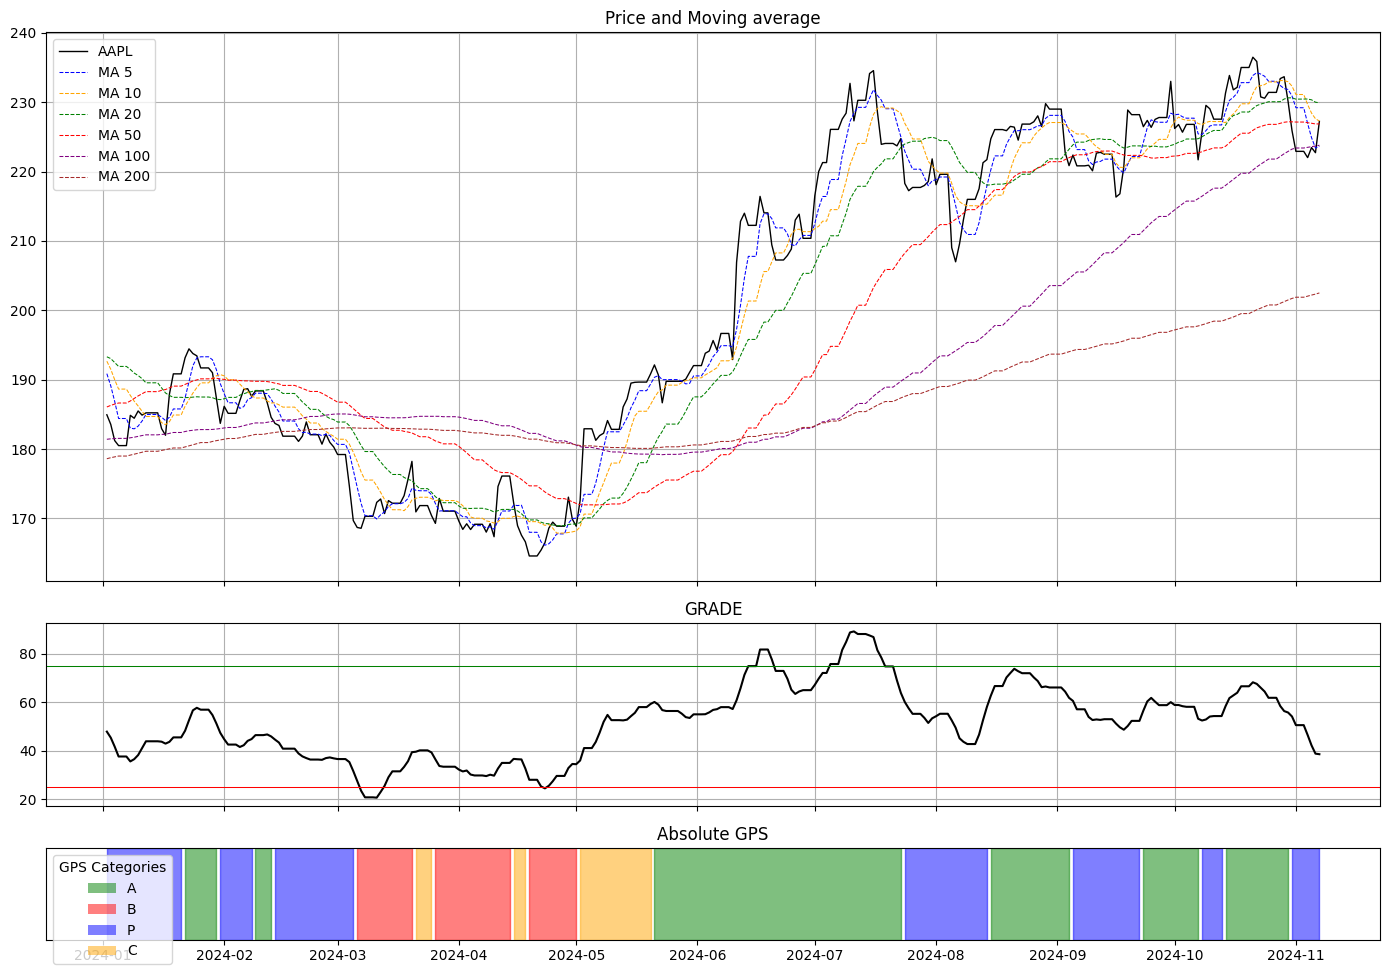

In [ ]:
ticker = 'AAPL'
history = yf.Ticker(ticker).history('max')['Close'].tz_localize(None).dropna()
history.name = ticker
df = eclairys_v1(history)
df = df.loc['2024':]
df = df.resample('D').ffill()

# Créer la figure et les sous-graphiques
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 0.5]})

# 1er graphique : Prix TSLA et moyennes mobiles
ax1.plot(df.index, df[ticker], label=ticker, color='black', linewidth=1)
ax1.plot(df.index, df['MA 5'], label='MA 5', linestyle='--', color='blue', linewidth=0.75)
ax1.plot(df.index, df['MA 10'], label='MA 10', linestyle='--', color='orange', linewidth=0.75)
ax1.plot(df.index, df['MA 20'], label='MA 20', linestyle='--', color='green', linewidth=0.75)
ax1.plot(df.index, df['MA 50'], label='MA 50', linestyle='--', color='red', linewidth=0.75)
ax1.plot(df.index, df['MA 100'], label='MA 100', linestyle='--', color='purple', linewidth=0.75)
ax1.plot(df.index, df['MA 200'], label='MA 200', linestyle='--', color='brown', linewidth=0.75)
ax1.legend(loc='upper left')
ax1.set_title('Price and Moving average')
ax1.grid(True)

# 2ème graphique : Note (GRADE)
ax2.plot(df.index, df['GRADE'], color='black')
ax2.axhline(y=75, color='green', linewidth=0.75)
ax2.axhline(y=25, color='red', linewidth=0.75)
ax2.set_title('GRADE')
ax2.grid(True)

# 3ème graphique : GPS avec bande de couleurs
gps_colors = {'A': 'green', 'B': 'red', 'P': 'blue', 'C': 'orange'}
for grade, color in gps_colors.items():
    mask = df['Absolute GPS'] == grade
    ax3.fill_between(df.index, 0, 1, where=mask, color=color, alpha=0.5, transform=ax3.get_xaxis_transform())

ax3.set_title('Absolute GPS')
ax3.set_yticks([])

# Ajouter la légende pour GPS
legend_elements = [Patch(facecolor='green', label='A', alpha=0.5),
                   Patch(facecolor='red', label='B', alpha=0.5),
                   Patch(facecolor='blue', label='P', alpha=0.5),
                   Patch(facecolor='orange', label='C', alpha=0.5)]
ax3.legend(handles=legend_elements, loc='upper left', title='GPS Categories')

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()

In [127]:
for ticker in tqdm(ticker_list):
    history = history_df[ticker]
    df = eclairys_v1(history)
    df.to_csv(os.getcwd() + '/eclairys/' + ticker + '.csv')

100%|██████████| 503/503 [02:14<00:00,  3.74it/s]


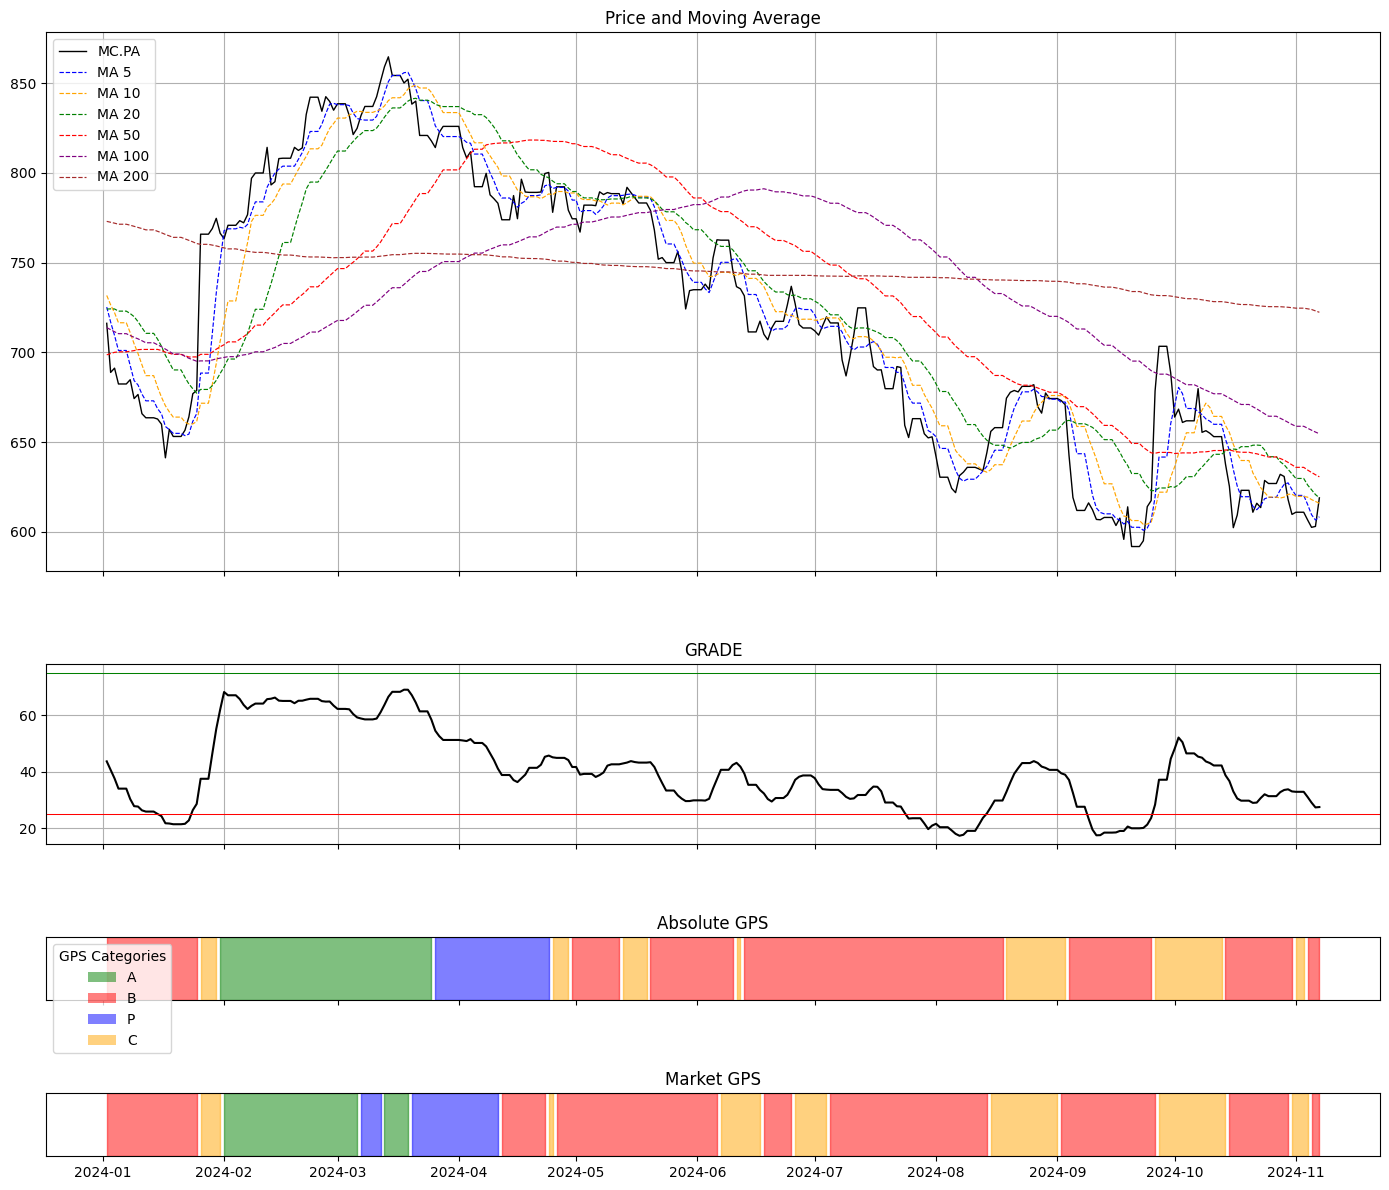

In [191]:
stock_ticker = 'MC.PA'
market_ticker = '^FCHI'

df = eclairys_v2(stock_ticker, market_ticker)
df = df.loc['2024':]
df = df.resample('D').ffill()

# Create figure and subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 0.35, 0.35]})

# 1st plot: TSLA Price and Moving Averages
ax1.plot(df.index, df[stock_ticker], label=stock_ticker, color='black', linewidth=1)
ax1.plot(df.index, df['MA 5'], label='MA 5', linestyle='--', color='blue', linewidth=0.85)
ax1.plot(df.index, df['MA 10'], label='MA 10', linestyle='--', color='orange', linewidth=0.85)
ax1.plot(df.index, df['MA 20'], label='MA 20', linestyle='--', color='green', linewidth=0.85)
ax1.plot(df.index, df['MA 50'], label='MA 50', linestyle='--', color='red', linewidth=0.85)
ax1.plot(df.index, df['MA 100'], label='MA 100', linestyle='--', color='purple', linewidth=0.85)
ax1.plot(df.index, df['MA 200'], label='MA 200', linestyle='--', color='brown', linewidth=0.85)
ax1.legend(loc='upper left')
ax1.set_title('Price and Moving Average')
ax1.grid(True)

# 2nd plot: GRADE
ax2.plot(df.index, df['GRADE'], color='black')
ax2.axhline(y=75, color='green', linewidth=0.75)
ax2.axhline(y=25, color='red', linewidth=0.75)
ax2.set_title('GRADE')
ax2.grid(True)

# 3rd plot: GPS with color bands
gps_colors = {'A': 'green', 'B': 'red', 'P': 'blue', 'C': 'orange'}
for grade, color in gps_colors.items():
    mask = df['Absolute GPS'] == grade
    ax3.fill_between(df.index, 0, 1, where=mask, color=color, alpha=0.5, transform=ax3.get_xaxis_transform())
ax3.set_title('Absolute GPS')
ax3.set_yticks([])

# 4th plot: Market GPS with color bands
for grade, color in gps_colors.items():
    mask = df['Market GPS'] == grade
    ax4.fill_between(df.index, 0, 1, where=mask, color=color, alpha=0.5, transform=ax4.get_xaxis_transform())
ax4.set_title('Market GPS')
ax4.set_yticks([])

# Add GPS legend
legend_elements = [Patch(facecolor='green', label='A', alpha=0.5),
                   Patch(facecolor='red', label='B', alpha=0.5),
                   Patch(facecolor='blue', label='P', alpha=0.5),
                   Patch(facecolor='orange', label='C', alpha=0.5)]
ax3.legend(handles=legend_elements, loc='upper left', title='GPS Categories')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()